In [1]:
import math as m
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
%matplotlib inline

Define function 'circles' that will plot coral colonies as circles using matplotlib
From here: http://stackoverflow.com/questions/9081553/python-scatter-plot-size-and-style-of-the-marker/24567352#24567352


In [2]:
def circles(x, y, s, c='b', ax=None, vmin=None, vmax=None, **kwargs):
    """
    Make a scatter of circles plot of x vs y, where x and y are sequence 
    like objects of the same lengths. The size of circles are in data scale.

    Parameters
    ----------
    x,y : scalar or array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ) 
        Radius of circle in data scale (ie. in data unit)
    c : color or sequence of color, optional, default : 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs.
        Note that `c` should not be a single numeric RGB or
        RGBA sequence because that is indistinguishable from an array of
        values to be colormapped.  `c` can be a 2-D array in which the
        rows are RGB or RGBA, however.
    ax : Axes object, optional, default: None
        Parent axes of the plot. It uses gca() if not specified.
    vmin, vmax : scalar, optional, default: None
        `vmin` and `vmax` are used in conjunction with `norm` to normalize
        luminance data.  If either are `None`, the min and max of the
        color array is used.  (Note if you pass a `norm` instance, your
        settings for `vmin` and `vmax` will be ignored.)

    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`

    Other parameters
    ----------------
    kwargs : `~matplotlib.collections.Collection` properties
        eg. alpha, edgecolors, facecolors, linewidths, linestyles, norm, cmap

    Examples
    --------
    a = np.arange(11)
    circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')

    License
    --------
    This code is under [The BSD 3-Clause License]
    (http://opensource.org/licenses/BSD-3-Clause)
    """
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection
    #import matplotlib.colors as colors

    if ax is None:
        ax = plt.gca()    

    if isinstance(c,basestring):
        color = c     # ie. use colors.colorConverter.to_rgba_array(c)
    else:
        color = None  # use cmap, norm after collection is created
    kwargs.update(color=color)

    if isinstance(x, (int, long, float)):
        patches = [Circle((x, y), s),]
    elif isinstance(s, (int, long, float)):
        patches = [Circle((x_,y_), s) for x_,y_ in zip(x,y)]
    else:
        patches = [Circle((x_,y_), s_) for x_,y_,s_ in zip(x,y,s)]
    collection = PatchCollection(patches, **kwargs)

    if color is None:
        collection.set_array(np.asarray(c))
        if vmin is not None or vmax is not None:
            collection.set_clim(vmin, vmax)

    ax.add_collection(collection)
    return collection

In [3]:
class Coral(object):
    """Define a coral colony as a circle with a diameter, disease state, and x,y location"""
    def __init__(self, diameter, disease, loc):
        self.diameter = diameter
        self.area = sp.pi*(diameter/2.)**2.
        self.disease = disease
        self.x = loc[0]
        self.y = loc[1]   
    def IsDiseased(self):
        if self.disease==1:
            print "Diseased"
        else:
            print "Healthy"

In [4]:
#Test Coral object
c01 = Coral(14,0,[3.21,4.445])
print c01.disease
c01.IsDiseased()
print c01.x
print c01.y
print c01.__doc__

0
Healthy
3.21
4.445
Define a coral colony as a circle with a diameter, disease state, and x,y location


In [226]:
class Landscape(object):
    """Define a reef landscape by its xy dimensions, mean & sd of the lognormal size freq dist, disease prevalence, and clumpiness
    
    reefdim: [x,y] dimensions in meters
    SFD: [mean,sd] of a lognormal size freq dist for coral colonies on the landscape
    prevalence: the probability that a colony on the landscape is diseased
    clump: not yet implemented; defaults to 0; will be a measure of the aggregation of colonies generated on the landscape
    
    Changes Needed: (1) BT and ET overestimate density bc of corners
                    (2) add more doc strings to methods
    """
    
    def __init__(self, reefdim, SFD, prevalence, clump=0):
        self.nCol = 0     #number of colonies
        self.xreef = reefdim[0]   #length of reef in x direction (50m)
        self.yreef = reefdim[1]   #length of reef in y direction (10m)
        self.SFDmu = SFD[0]   #mean of log(size) freq distribution of colonies (i.e., mean of log(diam/2))
        self.SFDsig = SFD[1] #sd of log(size) freq distribution of colonies (i.e., sd of log(diam/2))
        self.clump = clump   #clumpiness parameter (TBD)
        self.prevalence = prevalence #prob that a generated colony is diseased
        self.corals = []     #list of corals on this landscape
        
    def PredictCover(self, nc):
        sizes = np.random.lognormal(self.SFDmu,self.SFDsig,nc)
        pcover = sum(np.pi*(sizes/2.)**2)/(self.xreef*self.yreef)
        return float(pcover)
    
    def PercentCover(self):
        s = self.AttrList("diameter")
        pcover = sum(np.pi*(s/2.)**2)/(self.xreef*self.yreef)
        return float(pcover)
      
    def GenerateColonies(self, nc, counts=False, plot=False):
        start = time.clock()
        sizes = -np.sort(-np.random.lognormal(self.SFDmu,self.SFDsig,nc))
        print "Predicted Cover is " + "{:.2f}".format(self.PredictCover(nc))
        if plot is True:
            nplot = np.floor(nc/20)
        j = 0
        ct_rng = 0   #counter that increments for every random number generation
        ct_comp = 0  #counter that increments on every distance comparison
        rng = []
        comp = []
        while j <= (nc - 1):
            x_temp = np.random.uniform(low=0,high=self.xreef)  #random location between x= (0,xreef), and y = 0, yreef)
            y_temp = np.random.uniform(low=0,high=self.yreef)
            ct_rng += 1  #increment counter each time a random location is generated
            i = 0
            overlap = 0
            while (i < j) & (overlap == 0):
                d = m.sqrt((self.corals[i].x - x_temp)**2 + (self.corals[i].y - y_temp)**2)
                if d < (sizes[j]/2 + self.corals[i].diameter/2):
                    overlap = 1
                i += 1
                ct_comp += 1  
            if overlap == 0:
                prev = np.random.binomial(1,self.prevalence)
                self.corals.append(Coral(sizes[j],prev,[x_temp,y_temp]))
                j += 1
                self.nCol = j
                if plot == True:
                    if (j+1)%nplot == 0:
                        self.PlotLandscape() 
                rng.append(ct_rng)
                comp.append(ct_comp)
                ct_rng = 0 #reset counter for each new colony
                ct_comp = 0 #reset counter for each new colony
            if (ct_rng + 1)%1000000 ==0:
                print "ct_rng = " + str(ct_rng) + ", j = ", str(j)
            if ct_rng > self.nCol**3:
                print(["Stopped trying to place the ", j+1,"th colony after ",ct_rng," iterations"])
                break
        
        if counts is True:
            gentime = time.clock() - start
            plt.figure()
            plt.plot(rng)
            plt.xlabel('Colony Num')
            plt.ylabel('Number of Points generated before success')
            plt.figure()
            plt.plot(comp)
            plt.xlabel('Colony Num')
            plt.ylabel('Number of Distance Comparisons made before success')            
            print "{:.2f}".format(gentime) + "seconds to complete colony generation"
    
    def PlotLandscape(self, transect="none",**kwargs):
        from matplotlib.patches import Rectangle
        x = self.AttrList("x")
        y = self.AttrList("y")
        r = self.AttrList("diameter")/2.
        dis = self.AttrList("disease")
        disclr = []
        for i in range(self.nCol):
            if dis[i] == 1: 
                disclr.append("r")
            if dis[i] == 0:
                disclr.append("b")
        minorLocatorx = mpl.ticker.FixedLocator(range(0,self.xreef+1,1)) #for grid
        minorLocatory = mpl.ticker.FixedLocator(range(0,self.yreef+1,1))
        h=plt.figure(figsize = [3*self.xreef/self.yreef,3])
        ax = plt.gca()
        circles(x,y,r, edgecolor = disclr, facecolor='none')
        plt.title(str(self.nCol) + " colonies drawn from logNorm(" + str(self.SFDmu) + "," + str(self.SFDsig) +
                  ") and prev = " + str(self.prevalence))
        plt.xlim([0,self.xreef])
        plt.ylim([0,self.yreef])
        ax.xaxis.set_minor_locator(minorLocatorx)
        ax.yaxis.set_minor_locator(minorLocatory)
        plt.grid(b=True,which='both',axis='both')
        if 'transect' is "BT":
            ax.add_patch(Rectangle([kwargs['stpt'][0],kwargs['stpt'][1] - kwargs['width']/2.],
                                   kwargs['length'],kwargs['width'], ec='b',fc='none', lw=2.))
            ax.text(self.xreef*.75,self.yreef*.75,
                    "Counted: " + str(kwargs['ctcols']) + "\nDiseased: " + str(kwargs['ctdis']),
                    bbox={'facecolor':'white'})
        if 'transect' is "ET":
            ax.add_patch(Rectangle([kwargs['stpt'][0],kwargs['stpt'][1] - kwargs['ccwidth']/2.],
                                   kwargs['cclength'],kwargs['ccwidth'],ec='b',fc = 'none', lw=2.))
            ax.add_patch(Rectangle([kwargs['stpt'][0],kwargs['stpt'][1] - kwargs['dcwidth']/2.],
                                   kwargs['dclength'],kwargs['dcwidth'],ec='r', fc = 'none', lw=2.))
            ax.text(self.xreef*.75,self.yreef*.75,
                    "All Count: " + str(kwargs['ctcols']) + "\nDisease Count: " + str(kwargs['ctdis']),
                    bbox={'facecolor':'white'})
        if 'transect' is "LI":
            plt.plot([kwargs['stpt'][0],kwargs['stpt'][0]+kwargs['length']],[kwargs['stpt'][1],kwargs['stpt'][1]], 
                     color='b', linestyle='-', linewidth=2)  
            ax.text(self.xreef*.75,self.yreef*.75,
                    "All Count: " + str(kwargs['ctcols']) + "\nDisease Count: " + str(kwargs['ctdis']),
                    bbox={'facecolor':'white'})

    def PlotSFD(self):
        d = self.AttrList("diameter")
        plt.figure()
        plt.hist(d,30)
        plt.xlabel('Colony Diameter (m)')
        plt.title(["SFD: logN(" + str(self.SFDmu) + "," + str(self.SFDsig) + 
                   "), (mu,sig)-hat = " + "{:.2f}".format(np.mean(np.log(d))) + ",","{:.2f}".format(np.std(np.log(d)))])

    def BandTransect(self,stpt,length,width,plot=False): 
        if ((stpt[0] + length > self.xreef) | (stpt[1] + width/2. > self.yreef) | (stpt[1] - width/2. < 0)):
            return("Transect doesn't fit in landscape")
        if self.nCol ==0:
            return("No colonies on transect")
        ctcols=0
        ctdis=0
        for i in range(self.nCol):
            #want this to count only colonies >50% inside transect
            #right now, this still overcounts colonies in the corners
            inband = ((stpt[0] < self.corals[i].x < stpt[0] + length)  
                   & (stpt[1] - width/2. < self.corals[i].y < stpt[1] + width/2.))
            if inband: 
                ctcols += 1
                if self.corals[i].disease == 1:
                    ctdis += 1
        if 'plot' == True:
            self.PlotLandscape(transect="BT",stpt=stpt, length=length,width=width,ctcols=ctcols,ctdis=ctdis)
        return(ctcols, ctdis)
                                   
    def EstTransect(self,stpt,cclength,ccwidth,dclength,dcwidth,plot=False):
        # start point tuple, cc_length = coral count length, cc_width = coral count width
        # dc_length = disease count length, dc_width = disease count width
        if ((stpt[0] + cclength > self.xreef) | (stpt[1] + ccwidth/2. > self.yreef) | (stpt[1] - ccwidth/2. < 0) | \
            (stpt[0] + dclength > self.xreef) | (stpt[1] + dcwidth/2. > self.yreef) | (stpt[1] - dcwidth/2. < 0)):
            return("Transect doesn't fit in landscape")
        if self.nCol ==0:
            return("No colonies on transect")
        ctcols=0
        ctdis=0
        for i in range(self.nCol):
            #want this to count only colonies >50% inside transect
            #right now, this still overcounts colonies in the corners
            inCCband = ((stpt[0] < self.corals[i].x < stpt[0] + cclength) \
                     & (stpt[1] - ccwidth/2. < self.corals[i].y < stpt[1] + ccwidth/2.))
            inDCband = ((stpt[0] < self.corals[i].x < stpt[0] + dclength) \
                     & (stpt[1] - dcwidth/2. < self.corals[i].y < stpt[1] + dcwidth/2.))
            if inCCband:
                ctcols += 1
            if inDCband & self.corals[i].disease == 1:
                ctdis += 1
        if 'plot' == True:
            self.PlotLandscape(transect = "ET",stpt=stpt, cclength=cclength, ccwidth=ccwidth,
                               dclength=dclength, dcwidth=dcwidth, ctcols=ctcols,ctdis=ctdis)
        return(ctcols, ctdis)
                                   
    def LineIntercept(self, stpt, length, plot=False): 
        if (stpt[0] + length > self.xreef):
            return("Transect doesn't fit in landscape")
        if self.nCol ==0:
            return("No colonies on transect")
        ctcols = 0
        ctdis = 0
        for i in range(self.nCol):
            x_nearest = self.corals[i].x
            if self.corals[i].x > stpt[0] + length:
                x_nearest= stpt[0] + length
            elif self.corals[i].x < stpt[0]:
                x_nearest = stpt[0]
            ontransect = (m.sqrt((self.corals[i].y - stpt[1])**2) + (self.corals[i].x - x_nearest)**2) < self.corals[i].diameter/2.
            if ontransect:
                ctcols += 1
                if self.corals[i].disease == 1:
                    ctdis += 1
        if 'plot' == True:
            self.PlotLandscape(transect = "LI",stpt=stpt, length=length, ctcols=ctcols,ctdis=ctdis)
        return(ctcols,ctdis)
    
    def AttrList(self,attr):
        """return list of attribute (attr) from all corals on landscape"""       
        if self.nCol ==0:
            print "No corals on landscape"
            a = 0
            return a
        if attr in ["diameter", "x", "y"]:
            a = np.empty([self.nCol,1],dtype=float)
        if attr is "disease":
            a = np.empty([self.nCol,1],dtype=int)
        for i in range(self.nCol):
            a[i] = getattr(self.corals[i],attr)
        return a
        

Predicted Cover is 0.60
51.27seconds to complete colony generation
0.688056009629


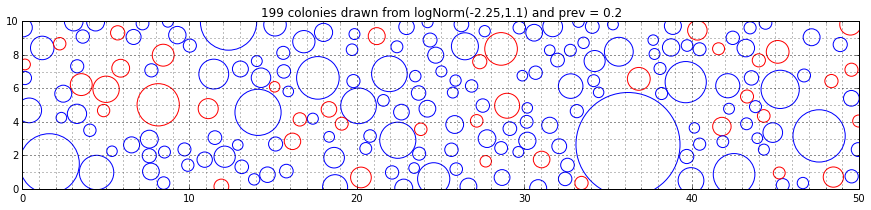

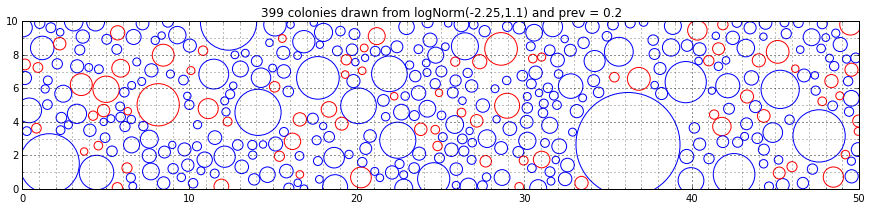

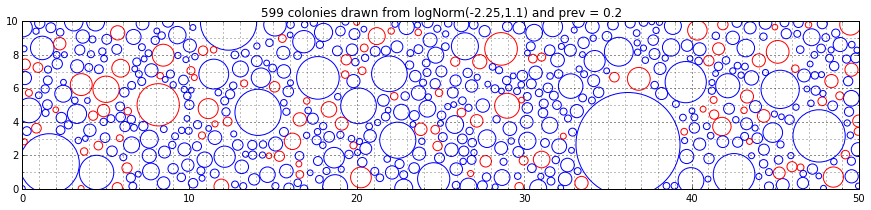

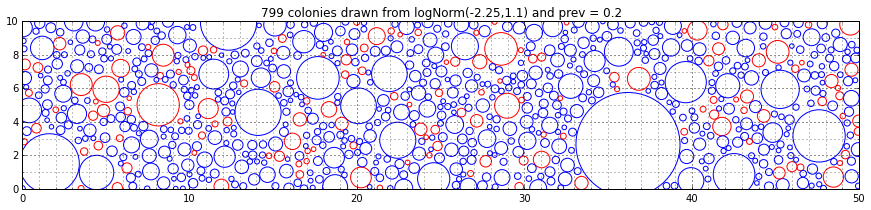

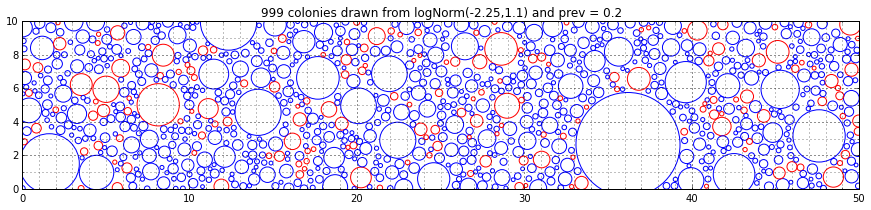

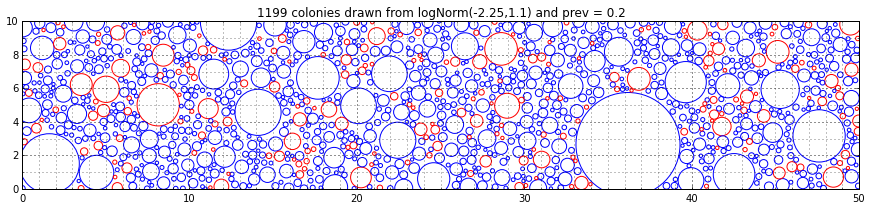

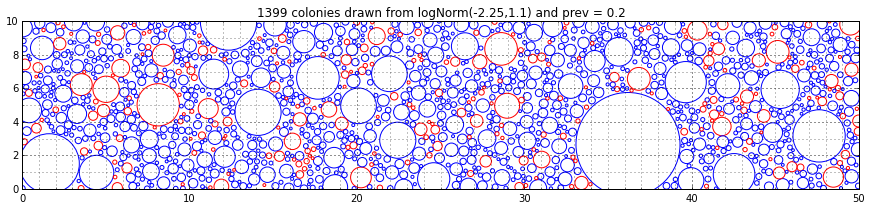

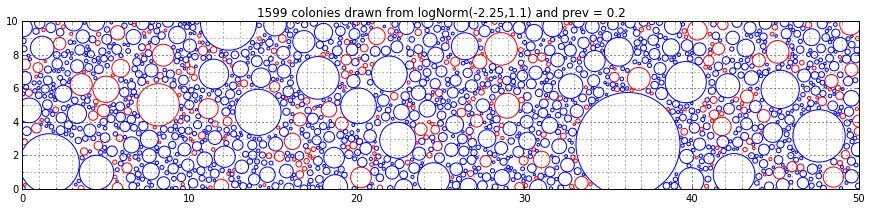

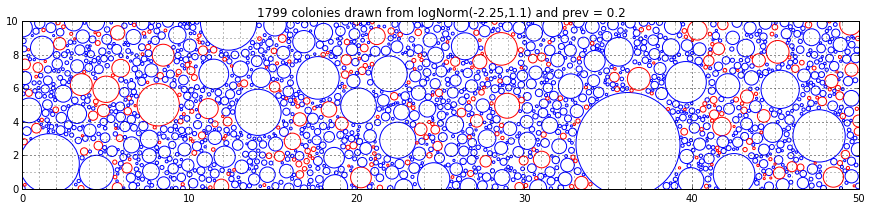

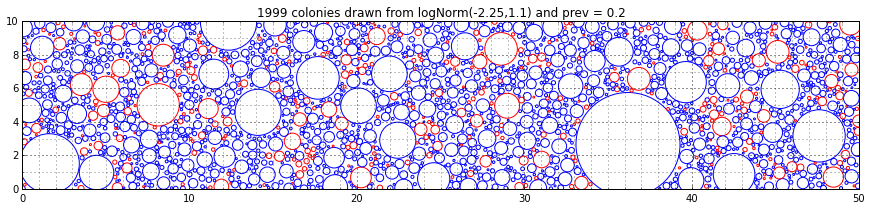

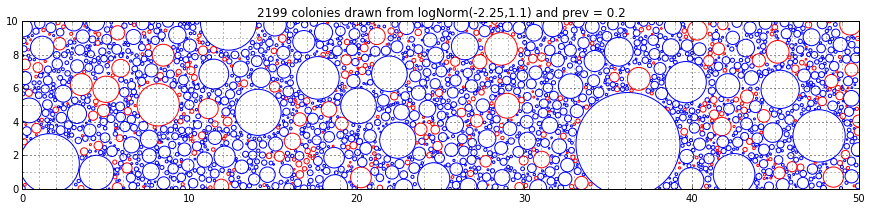

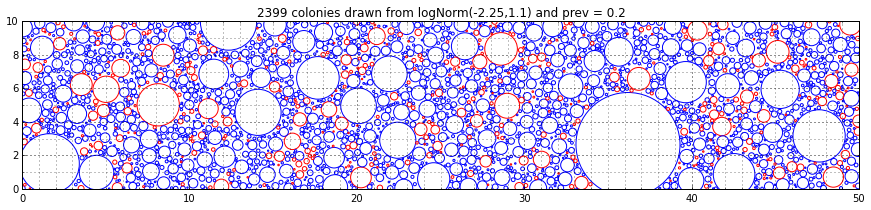

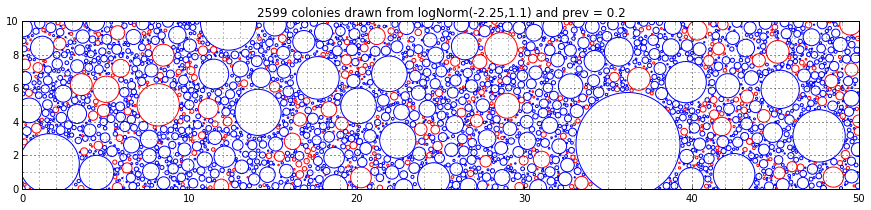

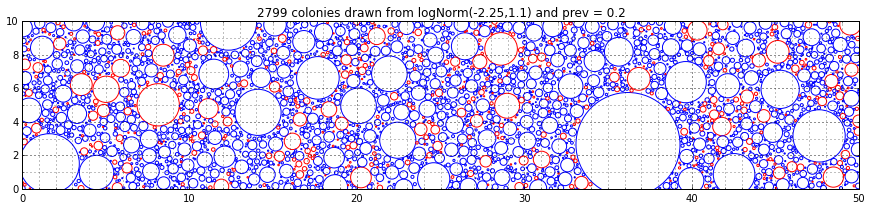

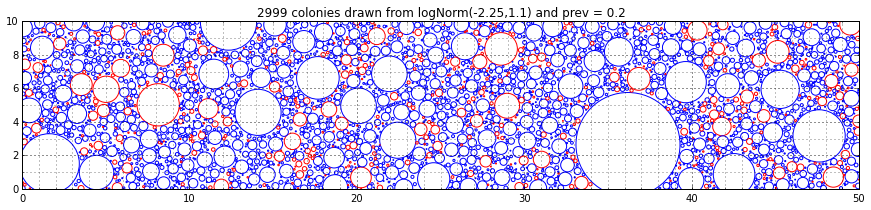

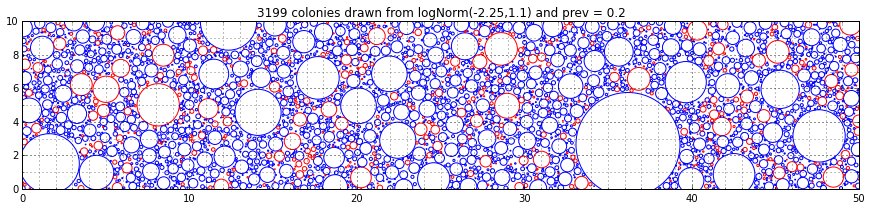

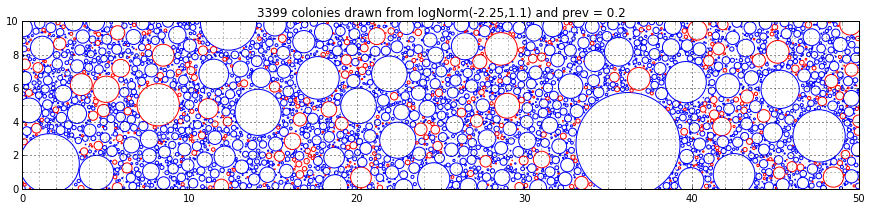

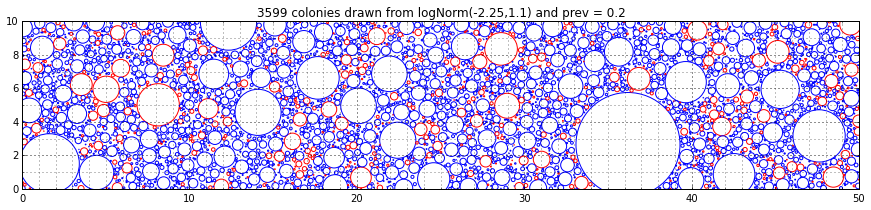

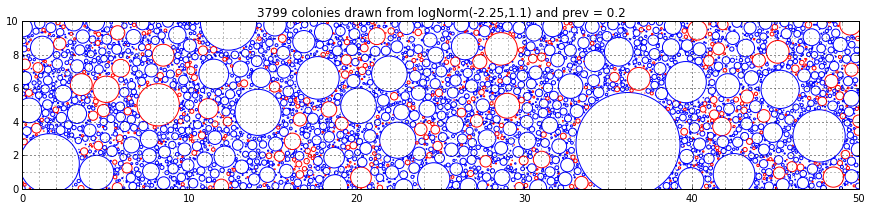

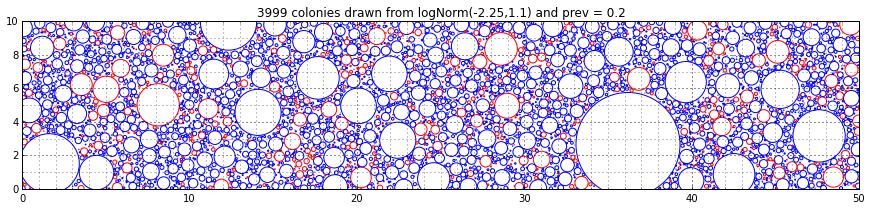

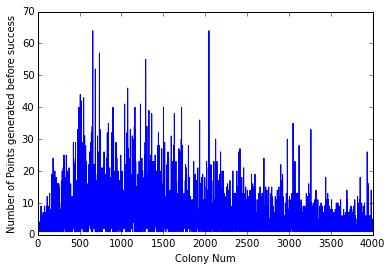

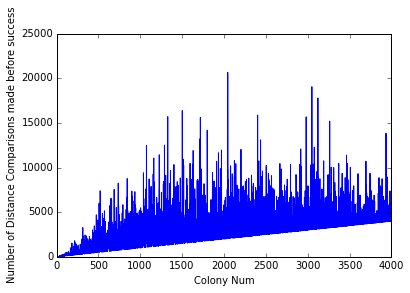

In [214]:
L02 = Landscape([50,10],[-2.25,1.1],0.2,0)
L02.GenerateColonies(4000, counts = True, plot= True)
print L02.PercentCover()


In [227]:
L02.BandTransect([5,5],25,2,plot=True)

(396, 68)

In [ ]:
L01 = Landscape([50,10],[-2.25,1.1],0.2,0)
print "Predicted %Cover = " + "{:.2f}".format(L01.PredictCover(1000)*100)
L01.GenerateColonies(1000,timer=True)
#print "Number of Colonies = " + "{0:02d}".format(L01.nCol)
#print "Calculated %Cover = " + "{:.2f}".format(L01.PercentCover()*100.)
#L01.BandTransect([5,5],25,2,True)
#L01.EstTransect([5,5],10,1,25,4,True)
#L01.LineIntercept([5,5],25,True)
